# Convolutional Neural Networks

**If you are a Colab user**

If you use Google Colab, you can uncomment the following cell to mount your Google Drive to Colab. After that, Clab can read/write files and data in your Google Drive

please change the current directory to be the folder that you save your Notebook and data folder. For example, I save my Colab files and data in the following location

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#%cd /content/drive/MyDrive/Colab\ Notebooks

**Example**

We use binary inspection image classification using the dataset NNdata as an example to illustrate the CNN models.

Each of the following models is built in stand-alone, which can be executed by only compiling that cell. 

## LeNet

We implement LeNet by modifying the input and output shapes. The model is trained from scrach.

Using device: cpu
Training samples: 768 | Validation samples: 192 | Test samples: 240
LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Epoch [ 1/100] Trn Loss: 0.6912 Trn Acc: 54.17% | Val Loss: 0.6875 Val Acc: 53.12%
Epoch [ 2/100] Trn Loss: 0.6885 Trn Acc: 56.64% | Val Loss: 0.6838 Val Acc: 54.17%
Epoch [ 3/100] Trn Loss: 0.6862 Trn Acc: 50.26% | Val Loss: 0.6823 Val Acc: 57.81%
Epoch [ 4/100] Trn Loss: 0.6836 Trn Acc: 51.30% | Val Loss: 0.6763 Val Acc: 56.77%
Epoch [ 5/100] Trn Loss: 0.6795 Trn Acc: 68.88% | Val Loss: 0.6707 Val Acc: 59.38%
Epoch [ 6/100] Trn Loss: 0.6721 Trn Acc: 60.03% | Val Loss: 0.6613 Val Acc: 6

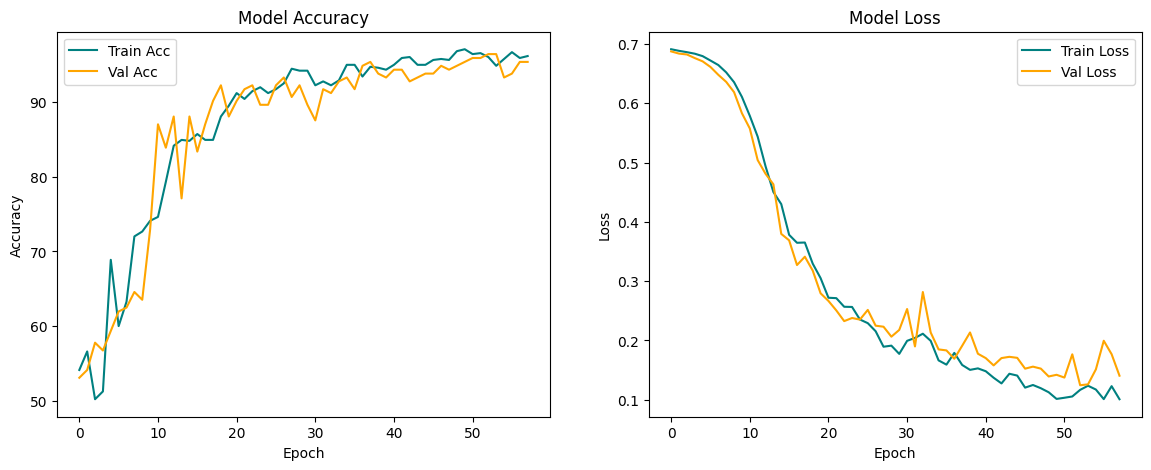

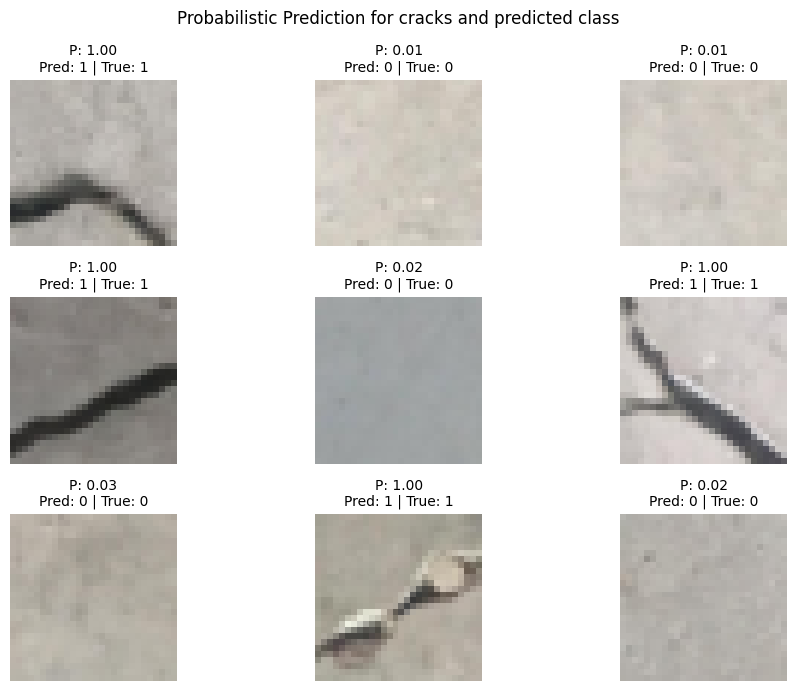

In [2]:
# === import libraries and modules that we need ===%
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt
import time
import random
import os

# === Hyperparameters === #
batch_size = 128
max_epochs = 100
max_wait = 5
eps_early = 1e-8
lr = 0.0005
checkpoint_filepath = 'Data/NNdata/model_best_weights_LeNet_CrackRec.pth'  # updated name

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Dataset setup === #
train_data_dir = 'Data/NNdata/train' 
test_data_dir = 'Data/NNdata/test'

img_width, img_height = 28, 28

# === Data preprocessing === #
train_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor()
])

full_train = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)

train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

print(f"Training samples: {len(train_dataset)} | Validation samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# ==== Define the LeNet Architecture === #
# This is the implementation of the LeNet CNN architecture, modified for the 3-channel input and the binary output.
# This is origionally introduced by Yann LeCun for handwritten digit recognition.
class LeNet(nn.Module):
    
    # define components of the network
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)

        # pooling layer
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    # define the forward propagation process, which put network components in the desired sequence from input to output
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x


# pass the model to the device
LeNet_model = LeNet().to(device)
print(LeNet_model)

# ==== Define Loss function and Optimizer ===#
loss_metric = nn.BCELoss()
optimizer = optim.Adam(LeNet_model.parameters(), lr=lr)

# === Model Training === #
best_val_loss = float('inf')
train_loss, val_loss = [], []
train_acc, val_acc = [], []
wait = 0

start_time = time.time()

for epoch in range(max_epochs):
    # Training
    LeNet_model.train() 
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = LeNet_model(images)
        loss = loss_metric(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_epoch_loss = train_running_loss / train_total
    train_epoch_acc = 100 * train_correct / train_total
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    # Validation
    LeNet_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = LeNet_model(images)
            loss = loss_metric(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = 100 * val_correct / val_total
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"Epoch [{epoch+1:2d}/{max_epochs}] "
          f"Trn Loss: {train_epoch_loss:.4f} Trn Acc: {train_epoch_acc:.2f}% | "
          f"Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.2f}%")

    # Early Stopping
    if val_epoch_loss < best_val_loss - eps_early:
        best_val_loss = val_epoch_loss
        wait = 0
        torch.save(LeNet_model.state_dict(), checkpoint_filepath)
    else:
        wait += 1
        if wait >= max_wait:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

end_time = time.time()
print('-------------------------------')
print(f"Training time: {end_time - start_time:.2f} seconds")

# === Evaluate Best Model on Test Dataset === #
print('\nLoading the best model and evaluating on the test set...')
LeNet_model.load_state_dict(torch.load(checkpoint_filepath))
LeNet_model.eval()

test_running_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = LeNet_model(images)
        loss = loss_metric(outputs, labels)
        test_running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_loss = test_running_loss / test_total
test_acc = 100 * test_correct / test_total

print(f"\nBest Model Performance on Test Set:")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%")


# ==== Plot Training History ===#
def plot_training(train_acc, val_acc, train_loss, val_loss):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(train_acc, 'teal', label='Train Acc')
    axs[0].plot(val_acc, 'orange', label='Val Acc')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper left')

    axs[1].plot(train_loss, 'teal', label='Train Loss')
    axs[1].plot(val_loss, 'orange', label='Val Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')
    plt.show()

plot_training(train_acc, val_acc, train_loss, val_loss)


# === Show predictions of samples in the test dataset === #
LeNet_model.eval()
all_images = []
all_labels = []
all_outputs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = LeNet_model(images)
        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_outputs.append(outputs.cpu())

all_images = torch.cat(all_images)
all_labels = torch.cat(all_labels)
all_outputs = torch.cat(all_outputs).numpy()

# Choose 9 random indices
random_indices = random.sample(range(len(all_images)), 9)

# Plot the predictions
fig = plt.figure(figsize=(10, 7))
fig.suptitle('Probabilistic Prediction for cracks and predicted class')

for k, i in enumerate(random_indices):
    ax = fig.add_subplot(3, 3, k+1)
    img = all_images[i].permute(1, 2, 0).numpy()  # CHW -> HWC
    plt.imshow(img)
    plt.axis('off')
    prob = all_outputs[i][0]
    pred_class = int(prob > 0.5)
    true_class = int(all_labels[i].item())
    plt.title(f'P: {prob:.2f}\nPred: {pred_class} | True: {true_class}', fontsize=10)

plt.tight_layout()
plt.show();


## A Self-designed CNN

We developed a CNN model by our self, which is trained from scrach.

Using device: cpu
Training samples: 768 | Validation samples: 192 | Test samples: 240
SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Epoch [ 1/100] Trn Loss: 0.6925 Trn Acc: 50.13% | Val Loss: 0.6899 Val Acc: 74.48%
Epoch [ 2/100] Trn Loss: 0.6878 Trn Acc: 56.64% | Val Loss: 0.6829 Val Acc: 60.42%
Epoch [ 3/100] Trn Loss: 0.6814 Trn Acc: 61.98% | Val Loss: 0.6740 Val Acc: 82.81%
Epoch [ 4/100] Trn Loss: 0.6686 Trn Acc: 70.05% | Val Loss: 0.6592 Val Acc: 84.90%
Epoch [ 5/100] Trn Loss: 0.6514 Trn Acc: 75.52% | Val Loss: 0.6303 Val Acc: 83.33%
Epoch [ 6/100] Trn Loss: 0.6223 Trn Acc: 78.52% | Val Loss: 0.5913 Val Acc: 7

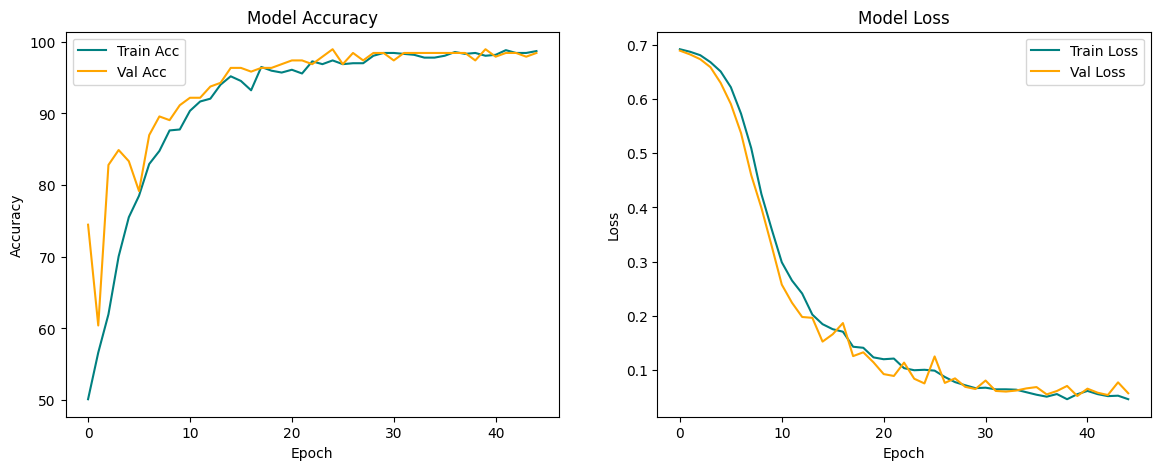

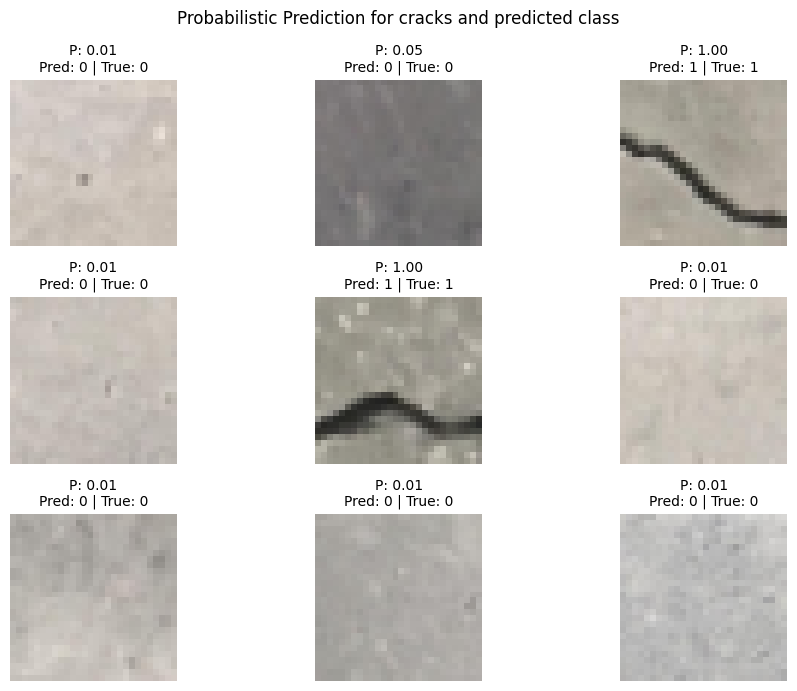

In [3]:
# === import libraries and modules that we need ===%
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt
import time
import random
import os

# === Hyperparameters === #
batch_size = 128
max_epochs = 100
max_wait = 5
eps_early = 1e-8
lr = 0.0005
checkpoint_filepath = 'Data/NNdata/model_best_weights_SimpleCNN_CrackRec.pth'  # updated name

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Dataset setup === #
train_data_dir = 'Data/NNdata/train' 
test_data_dir = 'Data/NNdata/test'

img_width, img_height = 28, 28

# === Data preprocessing === #
train_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor()
])

full_train = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)

train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

print(f"Training samples: {len(train_dataset)} | Validation samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# ==== Define the New CNN Architecture === #
class SimpleCNN(nn.Module):
    """
    A simplified CNN with two convolutional blocks and one fully connected layer.
    Uses ReLU activations, max pooling, and dropout regularization.
    """
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)  # -> 64x26x26   
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3) # -> 32x11x11   

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 1)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x


# pass the model to the device
cnn_model = SimpleCNN().to(device)
print(cnn_model)

# ==== Define Loss function and Optimizer ===#
loss_metric = nn.BCELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=lr)

# === Model Training === #
best_val_loss = float('inf')
train_loss, val_loss = [], []
train_acc, val_acc = [], []
wait = 0

start_time = time.time()

for epoch in range(max_epochs):
    # Training
    cnn_model.train() 
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = loss_metric(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_epoch_loss = train_running_loss / train_total
    train_epoch_acc = 100 * train_correct / train_total
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    # Validation
    cnn_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = cnn_model(images)
            loss = loss_metric(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = 100 * val_correct / val_total
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"Epoch [{epoch+1:2d}/{max_epochs}] "
          f"Trn Loss: {train_epoch_loss:.4f} Trn Acc: {train_epoch_acc:.2f}% | "
          f"Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.2f}%")

    # Early Stopping
    if val_epoch_loss < best_val_loss - eps_early:
        best_val_loss = val_epoch_loss
        wait = 0
        torch.save(cnn_model.state_dict(), checkpoint_filepath)
    else:
        wait += 1
        if wait >= max_wait:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

end_time = time.time()
print('-------------------------------')
print(f"Training time: {end_time - start_time:.2f} seconds")

# === Evaluate Best Model on Test Dataset === #
print('\nLoading the best model and evaluating on the test set...')
cnn_model.load_state_dict(torch.load(checkpoint_filepath))
cnn_model.eval()

test_running_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = cnn_model(images)
        loss = loss_metric(outputs, labels)
        test_running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_loss = test_running_loss / test_total
test_acc = 100 * test_correct / test_total

print(f"\nBest Model Performance on Test Set:")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%")


# ==== Plot Training History ===#
def plot_training(train_acc, val_acc, train_loss, val_loss):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(train_acc, 'teal', label='Train Acc')
    axs[0].plot(val_acc, 'orange', label='Val Acc')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper left')

    axs[1].plot(train_loss, 'teal', label='Train Loss')
    axs[1].plot(val_loss, 'orange', label='Val Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')
    plt.show()

plot_training(train_acc, val_acc, train_loss, val_loss)


# === Show predictions of samples in the test dataset === #
cnn_model.eval()
all_images = []
all_labels = []
all_outputs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = cnn_model(images)
        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_outputs.append(outputs.cpu())

all_images = torch.cat(all_images)
all_labels = torch.cat(all_labels)
all_outputs = torch.cat(all_outputs).numpy()

# Choose 9 random indices
random_indices = random.sample(range(len(all_images)), 9)

# Plot the predictions
fig = plt.figure(figsize=(10, 7))
fig.suptitle('Probabilistic Prediction for cracks and predicted class')

for k, i in enumerate(random_indices):
    ax = fig.add_subplot(3, 3, k+1)
    img = all_images[i].permute(1, 2, 0).numpy()  # CHW -> HWC
    plt.imshow(img)
    plt.axis('off')
    prob = all_outputs[i][0]
    pred_class = int(prob > 0.5)
    true_class = int(all_labels[i].item())
    plt.title(f'P: {prob:.2f}\nPred: {pred_class} | True: {true_class}', fontsize=10)

plt.tight_layout()
plt.show();

## Transfer AlexNet

Using device: cpu
Training: 768 | Validation: 192 | Test: 240
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
   

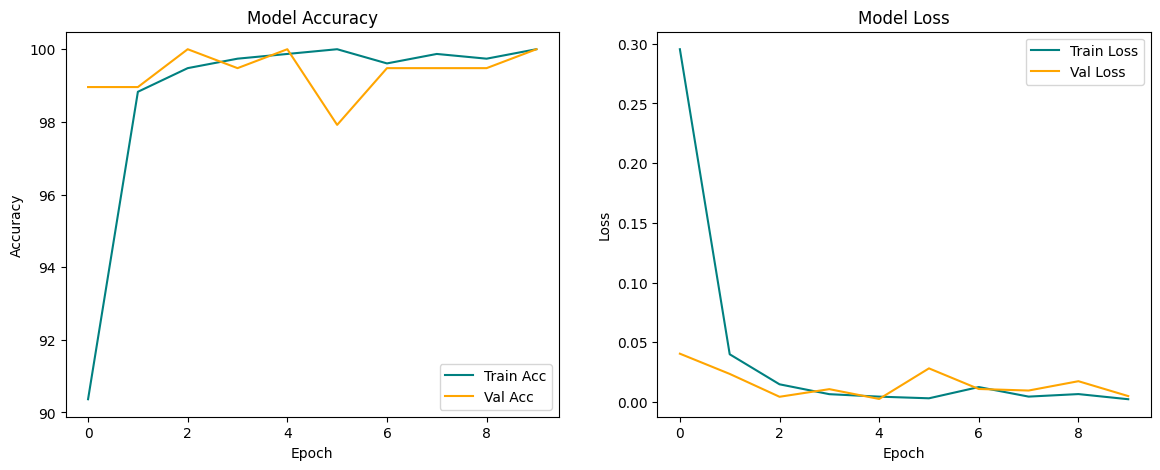

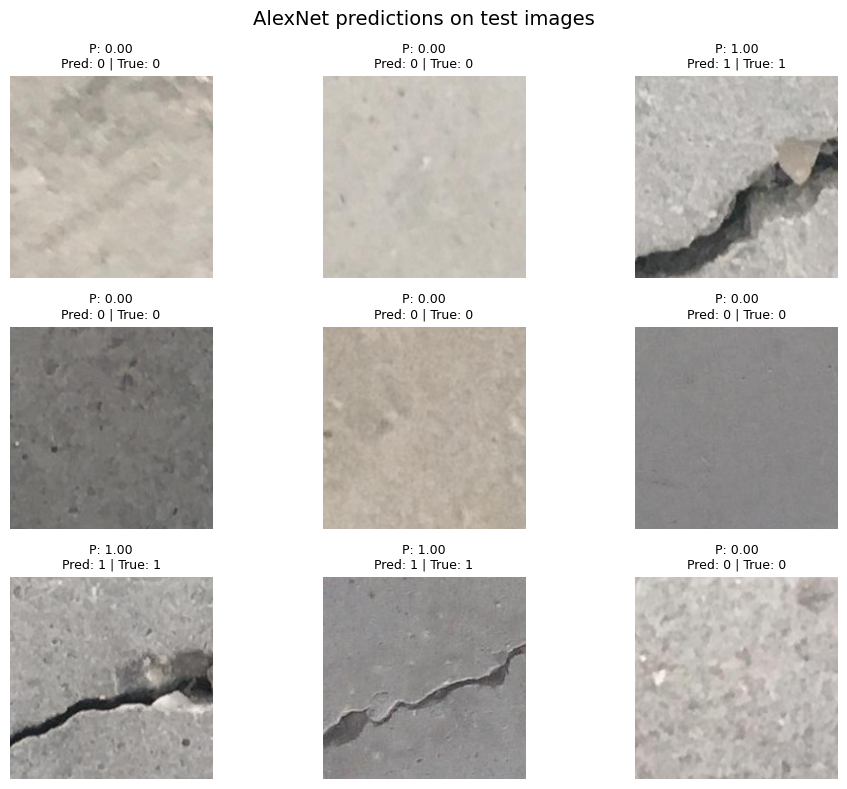

In [4]:
# === import libraries === #
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import random
import os

# === Hyperparameters === #
batch_size = 64
max_epochs = 50
max_wait = 5
eps_early = 1e-8
lr = 1e-4
checkpoint_filepath = 'Data/NNdata/model_best_weights_AlexNet_CrackRec.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Dataset setup === #
train_data_dir = 'Data/NNdata/train'
test_data_dir = 'Data/NNdata/test'

img_width, img_height = 224, 224   # AlexNet requires 224×224 input

# === Data preprocessing === #
train_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_train = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)

train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

print(f"Training: {len(train_dataset)} | Validation: {len(val_dataset)} | Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#////////////////////////////////////////////////////////////////////////////////////////#
#=== Transfer Learning ===#
#  Load Pretrained AlexNet
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# Freeze convolutional layers (feature extractor)
for param in alexnet.features.parameters():
    param.requires_grad = False

# Replace classifier for binary output
num_features = alexnet.classifier[6].in_features #number of input features
alexnet.classifier[6] = nn.Sequential( #classifier[6] is the last layer of the classifier
    nn.Linear(num_features, 1),
    nn.Sigmoid() 
)

alexnet = alexnet.to(device)
print(alexnet)
#////////////////////////////////////////////////////////////////////////////////////////#

# === Define Loss and Optimizer === #
loss_metric = nn.BCELoss()
optimizer = optim.Adam(alexnet.classifier.parameters(), lr=lr)

# === Model Training === #

# Training
best_val_loss = float('inf')
train_loss, val_loss = [], []
train_acc, val_acc = [], []
wait = 0

start_time = time.time()

for epoch in range(max_epochs):
    alexnet.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = alexnet(images)
        loss = loss_metric(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_epoch_loss = train_running_loss / train_total
    train_epoch_acc = 100 * train_correct / train_total
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    # Validation 
    alexnet.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = alexnet(images)
            loss = loss_metric(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = 100 * val_correct / val_total
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"Epoch [{epoch+1:2d}/{max_epochs}] "
          f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.2f}% | "
          f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.2f}%")

    # Early stopping
    if val_epoch_loss < best_val_loss - eps_early:
        best_val_loss = val_epoch_loss
        wait = 0
        torch.save(alexnet.state_dict(), checkpoint_filepath)
    else:
        wait += 1
        if wait >= max_wait:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

end_time = time.time()
print(f"\nTraining time: {end_time - start_time:.2f} seconds")

# === Test the best model === #
print('\nLoading the best model for test evaluation...')
alexnet.load_state_dict(torch.load(checkpoint_filepath))
alexnet.eval()

test_running_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = alexnet(images)
        loss = loss_metric(outputs, labels)
        test_running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_loss = test_running_loss / test_total
test_acc = 100 * test_correct / test_total

print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

# === Plot Training Curves === #
def plot_training(train_acc, val_acc, train_loss, val_loss):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(train_acc, 'teal', label='Train Acc')
    axs[0].plot(val_acc, 'orange', label='Val Acc')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    axs[1].plot(train_loss, 'teal', label='Train Loss')
    axs[1].plot(val_loss, 'orange', label='Val Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    plt.show()

plot_training(train_acc, val_acc, train_loss, val_loss)

# === Show predictions of 9 random test images === #
alexnet.eval()
all_images = []
all_labels = []
all_outputs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = alexnet(images)
        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_outputs.append(outputs.cpu())

all_images = torch.cat(all_images)
all_labels = torch.cat(all_labels)
all_outputs = torch.cat(all_outputs).numpy()

# Pick 9 random examples
random_indices = random.sample(range(len(all_images)), 9)

# Function to unnormalize ImageNet images for visualization
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img_tensor = img_tensor.permute(1, 2, 0)  # CHW → HWC
    img_tensor = img_tensor * std + mean
    return torch.clamp(img_tensor, 0, 1)

# Plot
fig = plt.figure(figsize=(10, 8))
fig.suptitle('AlexNet predictions on test images', fontsize=14)

for k, i in enumerate(random_indices):
    ax = fig.add_subplot(3, 3, k + 1)
    img = unnormalize(all_images[i])
    plt.imshow(img)
    plt.axis('off')
    prob = all_outputs[i][0]
    pred_class = int(prob > 0.5)
    true_class = int(all_labels[i].item())
    plt.title(f'P: {prob:.2f}\nPred: {pred_class} | True: {true_class}', fontsize=9)

plt.tight_layout()
plt.show();


## Transfer VGG-16

Using device: cpu
Training: 768, Validation: 192, Test: 240
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (1

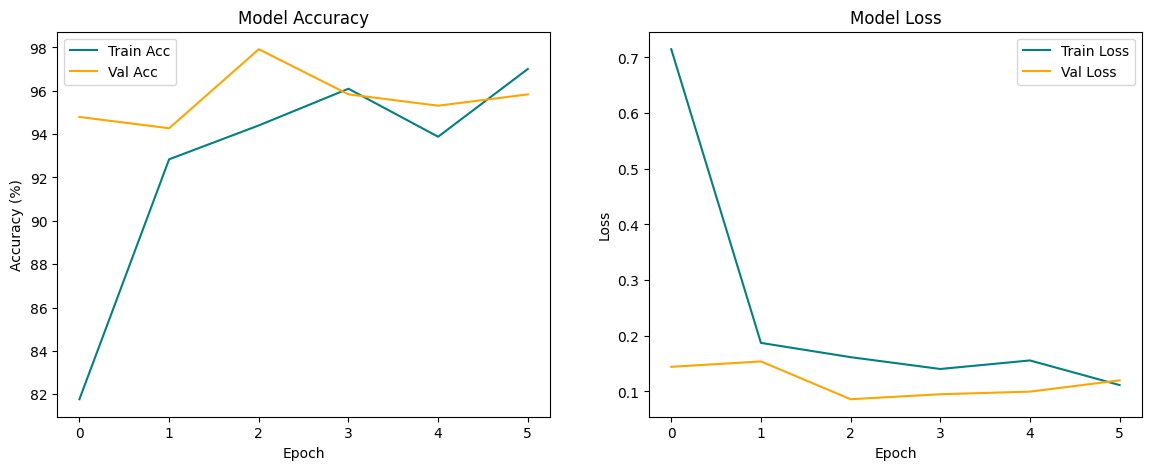

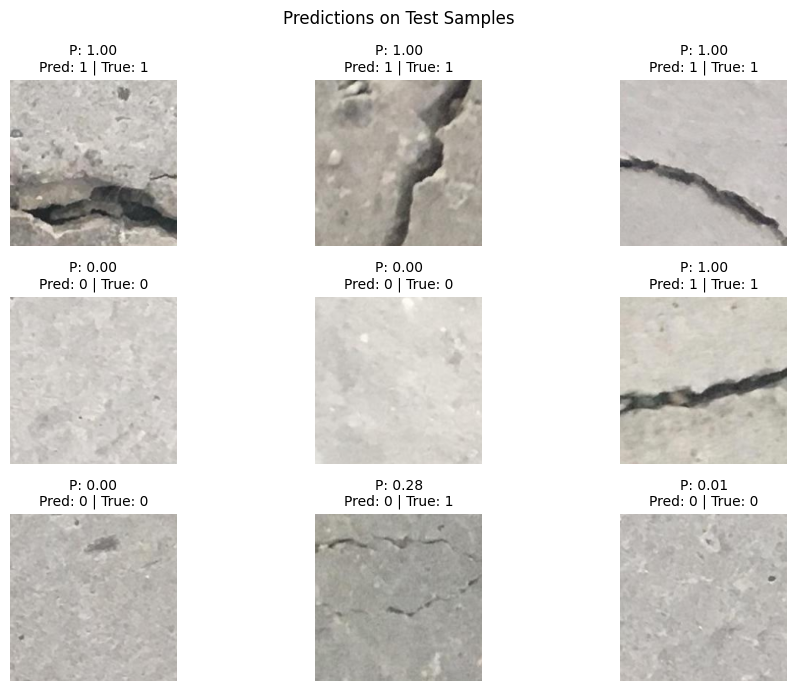

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import random
import os

# === Hyperparameters === #
batch_size = 32
max_epochs = 30
max_wait = 3
eps_early = 1e-8
lr = 0.01
checkpoint_filepath = 'Data/NNdata/model_best_weights_VGG16_CrackRec.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Dataset setup === #
train_data_dir = 'Data/NNdata/train' 
test_data_dir = 'Data/NNdata/test'
img_size = 224  # VGG16 input size

# === Data preprocessing === #
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_train = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)

train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

#/////////////////////////////////////////////////////////////////////////////////////////////////#
# === Transfer Learning === #
# Load Pretrained VGG16
vgg_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT) # recommended pre-trained weights

# Freeze convolutional base
for param in vgg_model.features.parameters():
    param.requires_grad = False

# Replace classifier for binary classification
num_ftrs = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

vgg_model = vgg_model.to(device)
print(vgg_model)
#/////////////////////////////////////////////////////////////////////////////////////////////////#


# === Loss function and optimizer === #
loss_metric = nn.BCELoss()
optimizer = optim.Adam(vgg_model.classifier[6].parameters(), lr=lr)

# === Model Training === #
best_val_loss = float('inf')
train_loss, val_loss = [], []
train_acc, val_acc = [], []
wait = 0
start_time = time.time()

for epoch in range(max_epochs):
    # Training
    vgg_model.train()
    train_running_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = vgg_model(images)
        loss = loss_metric(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_epoch_loss = train_running_loss / train_total
    train_epoch_acc = 100 * train_correct / train_total
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    # Validation
    vgg_model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = vgg_model(images)
            loss = loss_metric(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = 100 * val_correct / val_total
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"Epoch [{epoch+1:2d}/{max_epochs}] "
          f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.2f}% "
          f"| Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.2f}%")

    # Early stopping
    if val_epoch_loss < best_val_loss - eps_early:
        best_val_loss = val_epoch_loss
        wait = 0
        torch.save(vgg_model.state_dict(), checkpoint_filepath)
    else:
        wait += 1
        if wait >= max_wait:
            print(f"Early stopping at epoch {epoch+1}")
            break

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# === Load best model and evaluate === #
vgg_model.load_state_dict(torch.load(checkpoint_filepath))
vgg_model.eval()

def evaluate_model(loader):
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = vgg_model(images)
            loss = loss_metric(outputs, labels)
            running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, 100 * correct / total

test_loss, test_acc = evaluate_model(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

# === Plot training history === #
def plot_training(train_acc, val_acc, train_loss, val_loss):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(train_acc, 'teal', label='Train Acc')
    axs[0].plot(val_acc, 'orange', label='Val Acc')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy (%)')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper left')

    axs[1].plot(train_loss, 'teal', label='Train Loss')
    axs[1].plot(val_loss, 'orange', label='Val Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')

    plt.show()

plot_training(train_acc, val_acc, train_loss, val_loss)

# === Visualize 9 test samples with predictions === #
vgg_model.eval()
all_images, all_labels, all_outputs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = vgg_model(images)
        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_outputs.append(outputs.cpu())

all_images = torch.cat(all_images)
all_labels = torch.cat(all_labels)
all_outputs = torch.cat(all_outputs).numpy()

# Select 9 random samples
random_indices = random.sample(range(len(all_images)), 9)

fig = plt.figure(figsize=(10, 7))
fig.suptitle('Predictions on Test Samples')

for k, i in enumerate(random_indices):
    ax = fig.add_subplot(3, 3, k+1)
    img = all_images[i].permute(1, 2, 0).numpy()
    # Undo normalization
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.axis('off')
    prob = all_outputs[i][0]
    pred_class = int(prob > 0.5)
    true_class = int(all_labels[i].item())
    plt.title(f'P: {prob:.2f}\nPred: {pred_class} | True: {true_class}', fontsize=10)

plt.tight_layout()
plt.show()


## Transfer GoogLeNet

Using device: cpu
Training: 768, Validation: 192, Test: 240
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn):

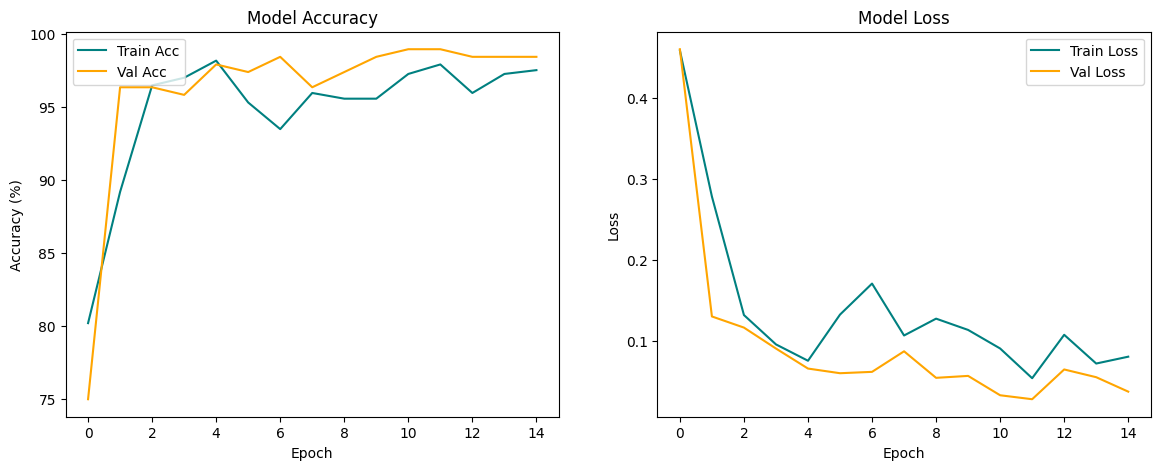

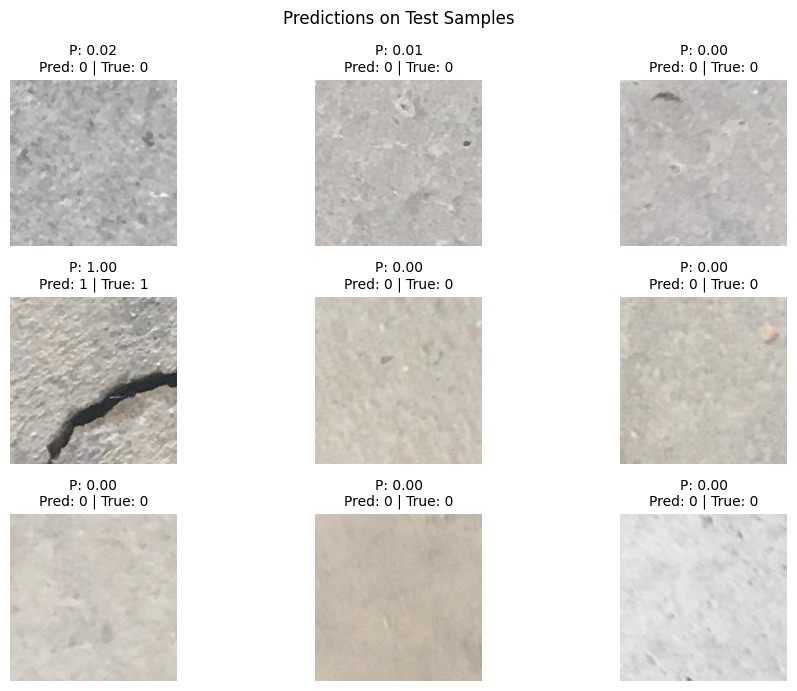

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import random
import os

# === Hyperparameters === #
batch_size = 32
max_epochs = 30
max_wait = 3
eps_early = 1e-8
lr = 0.001
checkpoint_filepath = 'Data/NNdata/model_best_weights_GoogleNet_CrackRec.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Dataset setup === #
train_data_dir = 'Data/NNdata/train'
test_data_dir = 'Data/NNdata/test'
img_size = 224

# === Data preprocessing === #
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_train = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)

train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

#//////////////////////////////////////////////////////////////////////////////////////////////////#
# === Transfer Learning === #

# Load pretrained GoogleNet (aux_logits=True by default)
googlenet_model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

# Disable aux_logits for training output
googlenet_model.aux_logits = False  # ignore auxiliary classifiers


# Freeze convolutional base
for param in googlenet_model.parameters():
    param.requires_grad = False

# Replace the classifier for binary classification
num_ftrs = googlenet_model.fc.in_features
googlenet_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

googlenet_model = googlenet_model.to(device)
print(googlenet_model)
#//////////////////////////////////////////////////////////////////////////////////////////////////#

# === Loss function and optimizer === #
loss_metric = nn.BCELoss()
optimizer = optim.Adam(googlenet_model.fc.parameters(), lr=lr)

# === Model Training === #
best_val_loss = float('inf')
train_loss, val_loss = [], []
train_acc, val_acc = [], []
wait = 0
start_time = time.time()

for epoch in range(max_epochs):
    # Training
    googlenet_model.train()
    train_running_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = googlenet_model(images)
        loss = loss_metric(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_epoch_loss = train_running_loss / train_total
    train_epoch_acc = 100 * train_correct / train_total
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    # Validation
    googlenet_model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = googlenet_model(images)
            loss = loss_metric(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = 100 * val_correct / val_total
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"Epoch [{epoch+1:2d}/{max_epochs}] "
          f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.2f}% "
          f"| Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.2f}%")

    # Early stopping
    if val_epoch_loss < best_val_loss - eps_early:
        best_val_loss = val_epoch_loss
        wait = 0
        torch.save(googlenet_model.state_dict(), checkpoint_filepath)
    else:
        wait += 1
        if wait >= max_wait:
            print(f"Early stopping at epoch {epoch+1}")
            break

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# === Load best model and evaluate === #
googlenet_model.load_state_dict(torch.load(checkpoint_filepath))
googlenet_model.eval()

def evaluate_model(loader):
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = googlenet_model(images)
            loss = loss_metric(outputs, labels)
            running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, 100 * correct / total

test_loss, test_acc = evaluate_model(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

# === Plot training history === #
def plot_training(train_acc, val_acc, train_loss, val_loss):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(train_acc, 'teal', label='Train Acc')
    axs[0].plot(val_acc, 'orange', label='Val Acc')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy (%)')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper left')

    axs[1].plot(train_loss, 'teal', label='Train Loss')
    axs[1].plot(val_loss, 'orange', label='Val Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')

    plt.show()

plot_training(train_acc, val_acc, train_loss, val_loss)

# === Visualize 9 test samples with predictions === #
googlenet_model.eval()
all_images, all_labels, all_outputs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = googlenet_model(images)
        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_outputs.append(outputs.cpu())

all_images = torch.cat(all_images)
all_labels = torch.cat(all_labels)
all_outputs = torch.cat(all_outputs).numpy()

# Select 9 random samples
random_indices = random.sample(range(len(all_images)), 9)

fig = plt.figure(figsize=(10, 7))
fig.suptitle('Predictions on Test Samples')

for k, i in enumerate(random_indices):
    ax = fig.add_subplot(3, 3, k+1)
    img = all_images[i].permute(1, 2, 0).numpy()
    # Undo normalization
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.axis('off')
    prob = all_outputs[i][0]
    pred_class = int(prob > 0.5)
    true_class = int(all_labels[i].item())
    plt.title(f'P: {prob:.2f}\nPred: {pred_class} | True: {true_class}', fontsize=10)

plt.tight_layout()
plt.show();


## Transfer ResNet18

Using device: cpu
Training: 768, Validation: 192, Test: 240
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

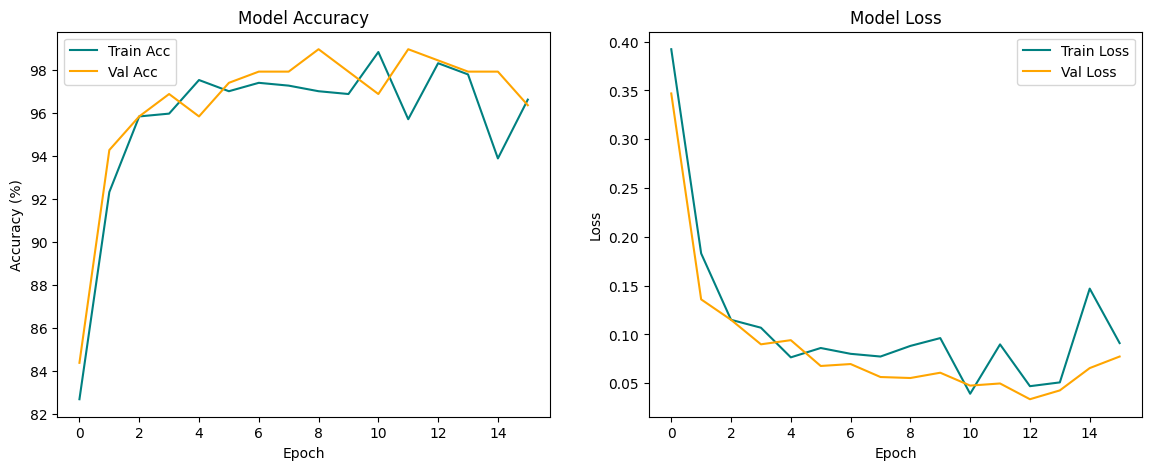

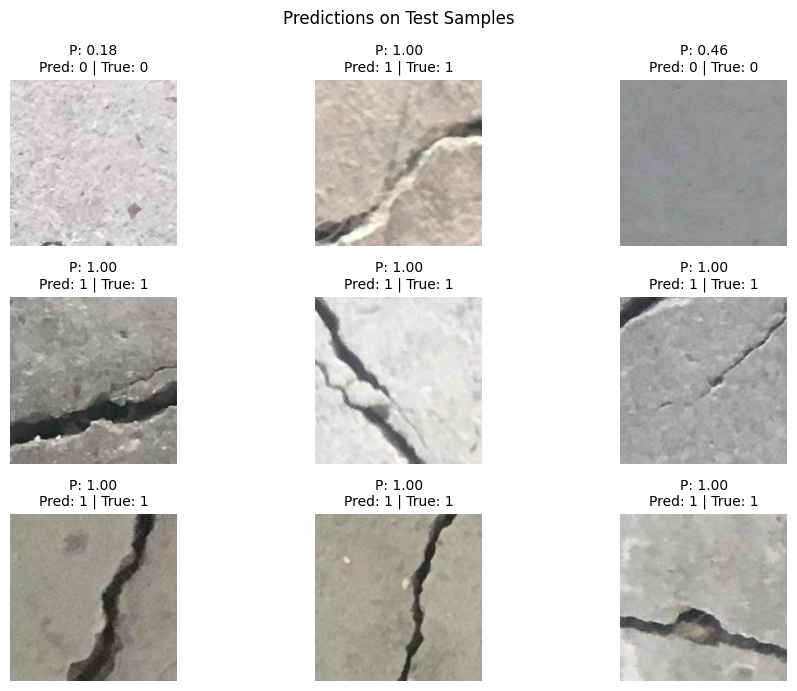

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import random
import os

# === Hyperparameters === #
batch_size = 32  # smaller for larger models
max_epochs = 30
max_wait = 3
eps_early = 1e-8
lr = 0.001
checkpoint_filepath = 'Data/NNdata/model_best_weights_ResNet_CrackRec.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Dataset setup === #
train_data_dir = 'Data/NNdata/train' 
test_data_dir = 'Data/NNdata/test'
img_size = 224  # ResNet standard input size

# === Data preprocessing === #
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Imagenet mean/std
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_train = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)

train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

#//////////////////////////////////////////////////////////////////////////////////////////////////#
# === Transfer Learning === #
# Load Pretrained ResNet
ResNet18_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)


# Freeze convolutional base
for param in ResNet18_model.parameters():
    param.requires_grad = False

# Replace the classifier for binary classification
num_ftrs = ResNet18_model.fc.in_features
ResNet18_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

ResNet18_model = ResNet18_model.to(device)
print(ResNet18_model)
#//////////////////////////////////////////////////////////////////////////////////////////////////#

# === Loss funcction and optimizer === #
loss_metric = nn.BCELoss()
optimizer = optim.Adam(ResNet18_model.fc.parameters(), lr=lr)

# === Model Training === #
best_val_loss = float('inf')
train_loss, val_loss = [], []
train_acc, val_acc = [], []
wait = 0
start_time = time.time()

for epoch in range(max_epochs):
    # Training
    ResNet18_model.train()
    train_running_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = ResNet18_model(images)
        loss = loss_metric(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_epoch_loss = train_running_loss / train_total
    train_epoch_acc = 100 * train_correct / train_total
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    # Validation
    ResNet18_model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = ResNet18_model(images)
            loss = loss_metric(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = 100 * val_correct / val_total
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"Epoch [{epoch+1:2d}/{max_epochs}] "
          f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.2f}% "
          f"| Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.2f}%")

    # Early stopping
    if val_epoch_loss < best_val_loss - eps_early:
        best_val_loss = val_epoch_loss
        wait = 0
        torch.save(ResNet18_model.state_dict(), checkpoint_filepath)
    else:
        wait += 1
        if wait >= max_wait:
            print(f"Early stopping at epoch {epoch+1}")
            break

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# === Load best model and evaluate === #
ResNet18_model.load_state_dict(torch.load(checkpoint_filepath))
ResNet18_model.eval()

def evaluate_model(loader):
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = ResNet18_model(images)
            loss = loss_metric(outputs, labels)
            running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, 100 * correct / total

test_loss, test_acc = evaluate_model(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")


# === Plot training history === #
def plot_training(train_acc, val_acc, train_loss, val_loss):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(train_acc, 'teal', label='Train Acc')
    axs[0].plot(val_acc, 'orange', label='Val Acc')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy (%)')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper left')

    axs[1].plot(train_loss, 'teal', label='Train Loss')
    axs[1].plot(val_loss, 'orange', label='Val Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')

    plt.show()

plot_training(train_acc, val_acc, train_loss, val_loss)


# === Visualize 9 test samples with predictions === #
ResNet18_model.eval()
all_images, all_labels, all_outputs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = ResNet18_model(images)
        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_outputs.append(outputs.cpu())

all_images = torch.cat(all_images)
all_labels = torch.cat(all_labels)
all_outputs = torch.cat(all_outputs).numpy()

# Select 9 random samples
random_indices = random.sample(range(len(all_images)), 9)

fig = plt.figure(figsize=(10, 7))
fig.suptitle('Predictions on Test Samples')

for k, i in enumerate(random_indices):
    ax = fig.add_subplot(3, 3, k+1)
    img = all_images[i].permute(1, 2, 0).numpy()
    # Undo normalization for visualization
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.axis('off')
    prob = all_outputs[i][0]
    pred_class = int(prob > 0.5)
    true_class = int(all_labels[i].item())
    plt.title(f'P: {prob:.2f}\nPred: {pred_class} | True: {true_class}', fontsize=10)

plt.tight_layout()
plt.show();



## Transfer DenseNet-161

Using device: cpu
Training: 768, Validation: 192, Test: 240
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, moment

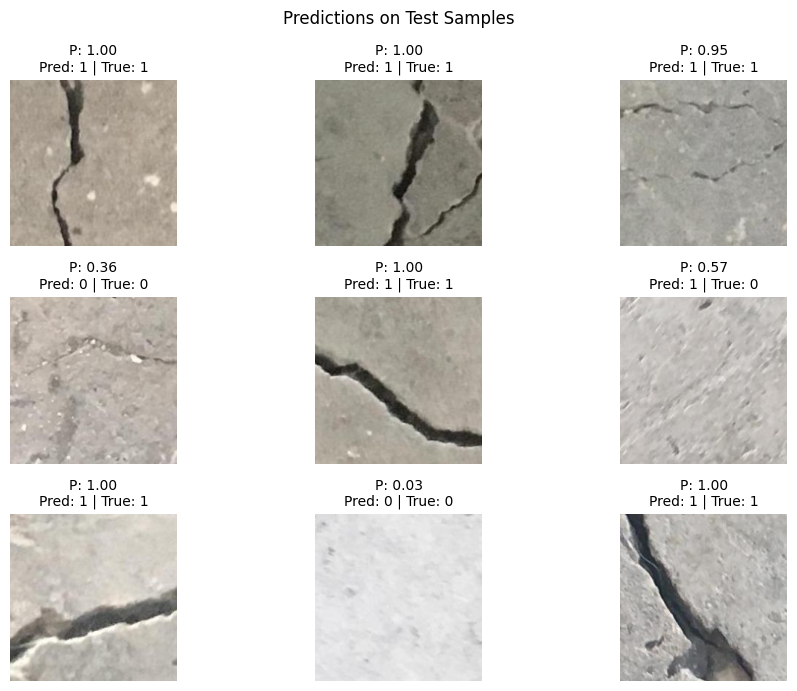

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import random
import os

# === Hyperparameters === #
batch_size = 32
max_epochs = 30
max_wait = 3
eps_early = 1e-8
lr = 0.001
checkpoint_filepath = 'Data/NNdata/model_best_weights_DenseNet_CrackRec.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Dataset setup === #
train_data_dir = 'Data/NNdata/train'
test_data_dir = 'Data/NNdata/test'
img_size = 224  # DenseNet standard input size

# === Data preprocessing === #
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_train = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)

train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

#//////////////////////////////////////////////////////////////////////////////////////////////////#
# === Transfer Learning with DenseNet-121 === #
# Load pre-trained DenseNet
DenseNet_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# Freeze convolutional/base layers
for param in DenseNet_model.parameters():
    param.requires_grad = False

# Replace classifier for binary classification
num_ftrs = DenseNet_model.classifier.in_features
DenseNet_model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

DenseNet_model = DenseNet_model.to(device)
print(DenseNet_model)
#//////////////////////////////////////////////////////////////////////////////////////////////////#

# === Loss function and optimizer === #
loss_metric = nn.BCELoss()
optimizer = optim.Adam(DenseNet_model.classifier.parameters(), lr=lr)

# === Model Training  === #
best_val_loss = float('inf')
train_loss, val_loss = [], []
train_acc, val_acc = [], []
wait = 0
start_time = time.time()

for epoch in range(max_epochs):
    # Training
    DenseNet_model.train()
    train_running_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = DenseNet_model(images)
        loss = loss_metric(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_epoch_loss = train_running_loss / train_total
    train_epoch_acc = 100 * train_correct / train_total
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    # Validation
    DenseNet_model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = DenseNet_model(images)
            loss = loss_metric(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = 100 * val_correct / val_total
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"Epoch [{epoch+1:2d}/{max_epochs}] "
          f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.2f}% "
          f"| Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.2f}%")

    # Early stopping
    if val_epoch_loss < best_val_loss - eps_early:
        best_val_loss = val_epoch_loss
        wait = 0
        torch.save(DenseNet_model.state_dict(), checkpoint_filepath)
    else:
        wait += 1
        if wait >= max_wait:
            print(f"Early stopping at epoch {epoch+1}")
            break

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# === Load best model and evaluate === #
DenseNet_model.load_state_dict(torch.load(checkpoint_filepath))
DenseNet_model.eval()

def evaluate_model(loader):
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = DenseNet_model(images)
            loss = loss_metric(outputs, labels)
            running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, 100 * correct / total

test_loss, test_acc = evaluate_model(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

# === Visualize 9 test samples with predictions === #
DenseNet_model.eval()
all_images, all_labels, all_outputs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = DenseNet_model(images)
        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_outputs.append(outputs.cpu())

all_images = torch.cat(all_images)
all_labels = torch.cat(all_labels)
all_outputs = torch.cat(all_outputs).numpy()

# Select 9 random samples
random_indices = random.sample(range(len(all_images)), 9)

fig = plt.figure(figsize=(10, 7))
fig.suptitle('Predictions on Test Samples')

for k, i in enumerate(random_indices):
    ax = fig.add_subplot(3, 3, k+1)
    img = all_images[i].permute(1, 2, 0).numpy()
    # Undo normalization for visualization
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.axis('off')
    prob = all_outputs[i][0]
    pred_class = int(prob > 0.5)
    true_class = int(all_labels[i].item())
    plt.title(f'P: {prob:.2f}\nPred: {pred_class} | True: {true_class}', fontsize=10)

plt.tight_layout()
plt.show();

